# [1] Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import cv2
from PIL import Image, ImageEnhance 
from sklearn.model_selection import train_test_split as tts
from keras.models import Sequential, Model 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model,to_categorical
import keras
from keras.optimizers import SGD
from keras import applications

from matplotlib import cm

In [3]:
from keras.layers import Conv2DTranspose,LeakyReLU,UpSampling2D,concatenate,Add,Activation,Lambda

from keras.layers import Lambda, LeakyReLU, Reshape, Add, Cropping2D, Conv2DTranspose, Permute, Conv2D, MaxPooling2D, Activation
from keras import backend as K

# [2.1] Reading Data 

In [4]:
grade=pd.read_csv('data/Grade.csv')

In [5]:
grade.head(5)

,name,patient ID,grade (GlaS),grade (Sirinukunwattana et al. 2015)
0,testA_1,4,benign,adenomatous
1,testA_10,10,benign,healthy
2,testA_11,9,benign,healthy
3,testA_12,11,malignant,poorly differentiated
4,testA_13,7,malignant,moderately differentiated


In [6]:
grade.columns

Index(['name', 'patient ID', ' grade (GlaS)',
       ' grade (Sirinukunwattana et al. 2015)'],
      dtype='object')

In [7]:
grade[' grade (GlaS)'].value_counts()

 malignant    91
 benign       74
Name:  grade (GlaS), dtype: int64

**Here we can see that the classes are little bit imbalanced but that won't affect our model**

In [8]:
classes=['benign ','malignant']

# [2.2] Dataset Augmentation

## Flipping Image Horizontally,Vertically and Both ways

In [9]:
def flip_image(image,image1):
    img_list=[]
    img_list_anno=[]    
    
    new=image1
    new=(image1>0).astype(np.int8)
    new=(new==1)*255
    new=new/255.
    
    
    #-----------------------------------------# Horizontal Flip-----------------------------------------------------
    img=cv2.flip(image,0)                  
    img=img/255.
    img_list.append(img)    
    
    img=cv2.flip(new,0)  
    img=np.reshape(img,(224,224,1))
    img_list_anno.append(img)
    #----------------------------------------# Vertical Flip-----------------------------------------------------------
    img=cv2.flip(image,1)                  
    img=img/255.
    img_list.append(img)
    
    img=cv2.flip(new,1)  
    img=np.reshape(img,(224,224,1))
    img_list_anno.append(img)    
    #-----------------------------------------# Both Way Flip---------------------------------------------------------
    img=cv2.flip(image,-1)                  
    img=img/255.
    img_list.append(img)
    
    img=cv2.flip(new,-1)  
    img=np.reshape(img,(224,224,1))
    img_list_anno.append(img)

    return img_list,img_list_anno

## Sharpening Image

In [10]:
def sharpen_image(image,image1):
    img_list=[]
    img_list_anno=[] 
    new=image1
    new=(image1>0).astype(np.int8)
    new=(new==1)*255    
    new=new/255.
    
    
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)
    image=image/255.
    img_list.append(image)
    
    new=np.reshape(new,(224,224,1))
    img_list_anno.append(new)
    
    return img_list,img_list_anno

## Adjusting Intensity

In [11]:
def intensity_adjust(image,image1):
    img_list=[]
    img_list_anno=[] 
    
    new=image1
    
    new=(image1>0).astype(np.int8)
    new=(new==1)*255
    new=new/255.
    #-----------------------------------# Low Intensity Image----------------------------------------------------------
    image=Image.fromarray(image.astype('uint8'), 'RGB')
    enhancer = ImageEnhance.Brightness(image) 
    enhanced_im = enhancer.enhance(4*0.2)                   
    enhanced_im=np.array(enhanced_im)
    enhanced_im=enhanced_im/255.
    img_list.append(enhanced_im)
    
    new=np.reshape(new,(224,224,1))
    img_list_anno.append(new)
    
    #------------------------------------ # High Intensity Image--------------------------------------------------
    enhanced_im = enhancer.enhance(6*0.2)                  
    enhanced_im=np.array(enhanced_im)
    enhanced_im=enhanced_im/255.
    img_list.append(enhanced_im)
    
    new=np.reshape(new,(224,224,1))
    img_list_anno.append(new)
    
    return img_list,img_list_anno

## Adding Noise

In [12]:
def add_noise(image,image1):
    img_list=[]
    img_list_anno=[]
    
    new=image1
    new=(image1>0).astype(np.int8)
    new=(new==1)*255
    new=new/255.
    
    noise=image.copy()
    noise=cv2.randn(noise, 0, 1)
    img_list.append(noise+image)
    
    new=np.reshape(new,(224,224,1))
    img_list_anno.append(new)
    
    return img_list,img_list_anno

## Dataset Creation

In [13]:
images_list=[]                                               # List of all images
images_label=[]                                              # List of all Labels
images_list_anno=[]                                          # List of all annotation map of images
for name,label in zip(grade['name'],grade[' grade (GlaS)']):
    img=cv2.imread('data/'+name+'.bmp')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  
    img=cv2.resize(img,(224,224))    
    images_list.append(img/255.)
    
    img1=cv2.imread('data/'+name+'_anno.bmp')
    img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)    
    img1=cv2.resize(img1,(224,224)) 
    img1=np.reshape(img1,(224,224,1))
    
    new=(img1>0).astype(np.int8)
    new=(new==1)*255
    new=new/255.
    images_list_anno.append(new)
    
    flipped_image,flipped_image_anno=flip_image(img,img1)
    images_list.extend(flipped_image)
    images_list_anno.extend(flipped_image_anno)
    
    sharp_image,sharp_image_anno=sharpen_image(img,img1)
    images_list.extend(sharp_image)
    images_list_anno.extend(sharp_image_anno)
    
    intensity_image,intensity_image_anno=intensity_adjust(img,img1)
    images_list.extend(intensity_image)
    images_list_anno.extend(intensity_image_anno)
    
    noise_image,noise_image_anno=add_noise(img/255.,img1)
    images_list.extend(noise_image)
    images_list_anno.extend(noise_image_anno)
    
    for i in range(len(flipped_image)+len(sharp_image)+len(intensity_image)+len(noise_image)+1):
        if label==' benign':
            images_label.append([1,0])
        else:
            images_label.append([0,1])
# images_list.extend(images_list)
# images_label.extend(images_label)
images_list_anno=np.array(images_list_anno)
images_list=np.array(images_list)
images_label=np.array(images_label)

In [14]:
images_list.shape

(1320, 224, 224, 3)

In [15]:
images_label.shape

(1320, 2)

In [16]:
images_list_anno.shape

(1320, 224, 224, 1)

# [3] Plotting Dataset Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


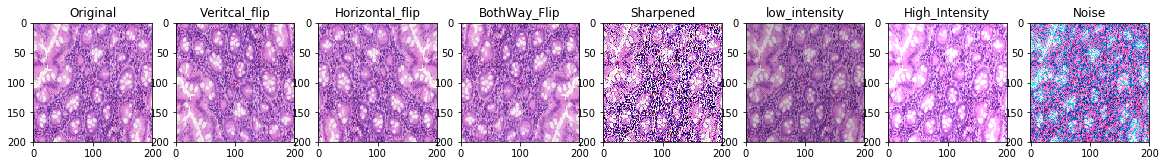

In [14]:
idx=20
fig,axs=plt.subplots(1,8,figsize=(20,20))
axs=axs.ravel()
titles=['Original','Veritcal_flip','Horizontal_flip','BothWay_Flip','Sharpened','low_intensity','High_Intensity','Noise']
for i in range(8):
    axs[i].imshow(images_list[idx*8+i])
    axs[i].set_title(titles[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


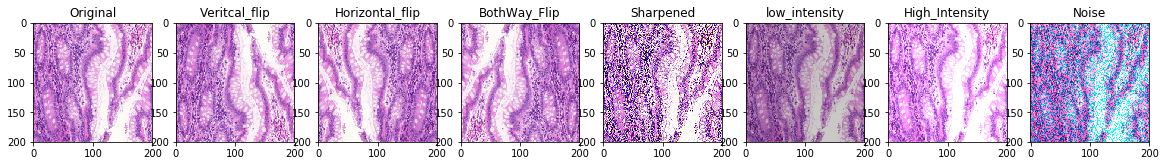

In [14]:
idx=30
fig,axs=plt.subplots(1,8,figsize=(20,20))
axs=axs.ravel()
titles=['Original','Veritcal_flip','Horizontal_flip','BothWay_Flip','Sharpened','low_intensity','High_Intensity','Noise']
for i in range(8):
    axs[i].imshow(images_list[idx*8+i])
    axs[i].set_title(titles[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


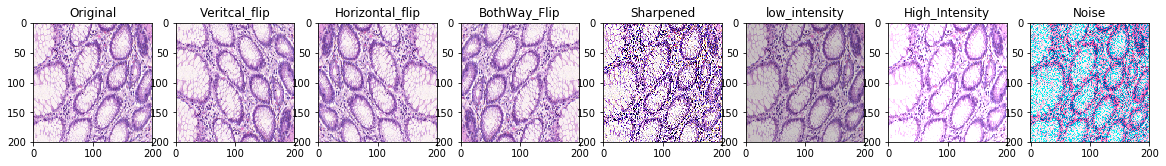

In [15]:
idx=40
fig,axs=plt.subplots(1,8,figsize=(20,20))
axs=axs.ravel()
titles=['Original','Veritcal_flip','Horizontal_flip','BothWay_Flip','Sharpened','low_intensity','High_Intensity','Noise']
for i in range(8):
    axs[i].imshow(images_list[idx*8+i])
    axs[i].set_title(titles[i])

# [4] Train-Test Split

In [16]:
x_train,x_test,y_train,y_test=tts(images_list,images_label)

# [5] Transfer Learning using VGG19

## [5.1] Classification 

### Model Creation

In [32]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

### Removing top layers and including our own layers

In [33]:
for layer in model.layers[:5]:
    layer.trainable = False
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation="softmax")(x)

In [34]:

model_final = Model(input = model.input, output = predictions)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


### Training

In [35]:
model_final.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [36]:
trainingHistory = model_final.fit(x_train, y_train, batch_size=16, 
                            epochs=15,
                            #validation_split=0.3,
                            validation_data=(x_test,y_test) ,
                            #callbacks=[early_stopping], 
                            shuffle=True,)

Train on 990 samples, validate on 330 samples
Epoch 1/15
990/990 [==============================] - 33s 33ms/step - loss: 0.7150 - acc: 0.6343 - val_loss: 0.3631 - val_acc: 0.8152
Epoch 2/15
990/990 [==============================] - 30s 30ms/step - loss: 0.3234 - acc: 0.8646 - val_loss: 0.4274 - val_acc: 0.7970
Epoch 3/15
990/990 [==============================] - 30s 30ms/step - loss: 0.2398 - acc: 0.8970 - val_loss: 0.0808 - val_acc: 0.9727
Epoch 4/15
990/990 [==============================] - 30s 30ms/step - loss: 0.1333 - acc: 0.9525 - val_loss: 0.0591 - val_acc: 0.9818
Epoch 5/15
990/990 [==============================] - 30s 30ms/step - loss: 0.0849 - acc: 0.9667 - val_loss: 0.1545 - val_acc: 0.9576
Epoch 6/15
990/990 [==============================] - 30s 30ms/step - loss: 0.0574 - acc: 0.9798 - val_loss: 0.0477 - val_acc: 0.9848
Epoch 7/15
990/990 [==============================] - 30s 30ms/step - loss: 0.0361 - acc: 0.9869 - val_loss: 0.1504 - val_acc: 0.9424
Epoch 8/15
990/9

### Model Accuracy

In [39]:
scores = model_final.evaluate(x_test, y_test)
print('%s: %.2f%%'% ("Accuracy", scores[1]*100))

330/330 [==============================] - 5s 17ms/step
Accuracy: 99.09%


### Performance

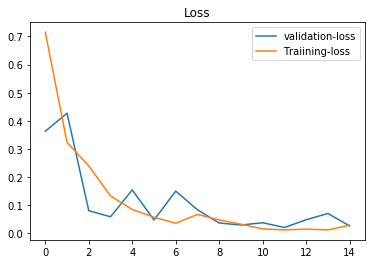

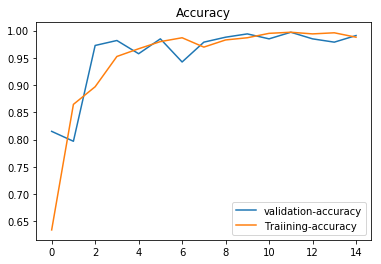

In [40]:
val_loss=trainingHistory.history['val_loss']
val_acc=trainingHistory.history['val_acc']
train_acc=trainingHistory.history['acc']
train_loss=trainingHistory.history['loss']

plt.plot(val_loss,label='validation-loss')
plt.plot(train_loss,label='Traiining-loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(val_acc,label='validation-accuracy')
plt.plot(train_acc,label='Traiining-accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

### Testing Images

In [47]:
def plot_image(image,org,prediction):    
    plt.imshow(np.reshape(image,(224,224,3)))
    plt.title("Original Image")
    print("Original Class:-  "+str(classes[np.argmax(org)]))
    print("predicted Class:-  "+str(classes[np.argmax(prediction)]))

Original Class:-  benign 
predicted Class:-  benign 


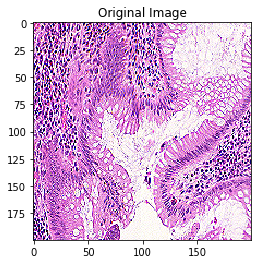

In [51]:
idx=94
image=np.reshape(x_test[idx],(1,224,224,3))
org=y_test[idx]
prediction=model_final.predict(image)
plot_image(image,org,prediction)

Original Class:-  malignant
predicted Class:-  malignant


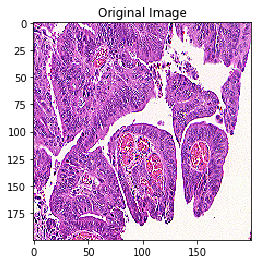

In [54]:
idx=10
image=np.reshape(x_test[idx],(1,224,224,3))
org=y_test[idx]
prediction=model_final.predict(image)
plot_image(image,org,prediction)

Original Class:-  benign 
predicted Class:-  benign 


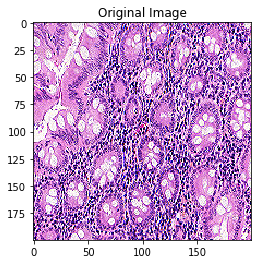

In [55]:
idx=100
image=np.reshape(x_test[idx],(1,224,224,3))
org=y_test[idx]
prediction=model_final.predict(image)
plot_image(image,org,prediction)

Original Class:-  benign 
predicted Class:-  benign 


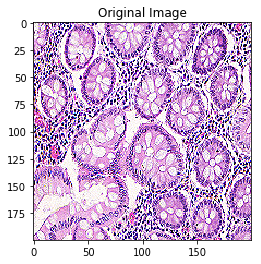

In [58]:
idx=130
image=np.reshape(x_test[idx],(1,224,224,3))
org=y_test[idx]
prediction=model_final.predict(image)
plot_image(image,org,prediction)

Original Class:-  malignant
predicted Class:-  malignant


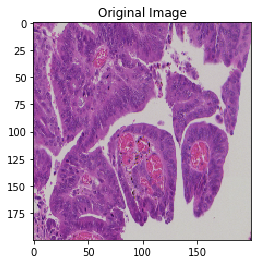

In [59]:
idx=190
image=np.reshape(x_test[idx],(1,224,224,3))
org=y_test[idx]
prediction=model_final.predict(image)
plot_image(image,org,prediction)

## [5.2] Image Segmentation

### Model Creation

In [21]:
#----------------------------------------Pretrained Encoder network--------------------------------------------
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
#####--------------------------------Decoder Network------------------------------------------------------

up1=concatenate([UpSampling2D((2, 2))(model.layers[-2:][0].output), model.layers[-7:][0].output], axis=-1)
conv6=Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
conv6=Dropout(0.5)(conv6)
conv6=Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up2=concatenate([UpSampling2D((2, 2))(conv6), model.layers[-12:][0].output], axis=-1)
conv7=Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
conv7=Dropout(0.5)(conv7)
conv7=Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up3=concatenate([UpSampling2D((2, 2))(conv7),model.layers[-17:][0].output], axis=-1)
conv8=Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
conv8=Dropout(0.5)(conv8)
conv8=Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up4=concatenate([UpSampling2D((2, 2))(conv8), model.layers[-20:][0].output], axis=-1)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
conv9 = Dropout(0.6)(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

conv10=Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)
# flatten = Lambda(lambda y: K.squeeze(y, -1))(Activation('sigmoid')(Reshape((224*224, 1))(conv10)))

In [24]:
new_model = Model(input = model.layers[0].input, output = conv10)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [25]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

### Model Training

In [26]:
new_model.compile(loss = "binary_crossentropy", optimizer ="adam", metrics=["accuracy"])

In [46]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
trainingHistory = new_model.fit(images_list, images_list_anno, batch_size=8, 
                            epochs=15,
                            validation_split=0.3,
                            #validation_data=(x_test,y_test) ,
                            callbacks=[early_stopping], 
                            shuffle=True,)

Train on 923 samples, validate on 397 samples
Epoch 1/15
923/923 [==============================] - 116s 125ms/step - loss: 0.2387 - acc: 0.8986 - val_loss: 0.2926 - val_acc: 0.8742
Epoch 2/15
923/923 [==============================] - 116s 126ms/step - loss: 0.2112 - acc: 0.9110 - val_loss: 0.3089 - val_acc: 0.8739
Epoch 3/15
923/923 [==============================] - 116s 126ms/step - loss: 0.2134 - acc: 0.9100 - val_loss: 0.3214 - val_acc: 0.8706
Epoch 4/15
923/923 [==============================] - 116s 126ms/step - loss: 0.1804 - acc: 0.9254 - val_loss: 0.3119 - val_acc: 0.8791
Epoch 5/15
923/923 [==============================] - 116s 126ms/step - loss: 0.1681 - acc: 0.9305 - val_loss: 0.3486 - val_acc: 0.8612
Epoch 6/15
923/923 [==============================] - 116s 126ms/step - loss: 0.1605 - acc: 0.9345 - val_loss: 0.3177 - val_acc: 0.8825
Epoch 7/15
923/923 [==============================] - 116s 126ms/step - loss: 0.1638 - acc: 0.9329 - val_loss: 0.3367 - val_acc: 0.8818
Ep

### Model Accuracy

In [51]:
scores = new_model.evaluate(images_list, images_list_anno)
print('%s: %.2f%%'% ("Accuracy", scores[1]*100))

1320/1320 [==============================] - 64s 48ms/step
Accuracy: 93.43%


### Model Performance

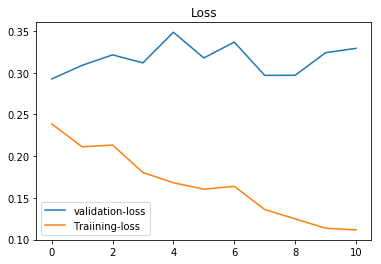

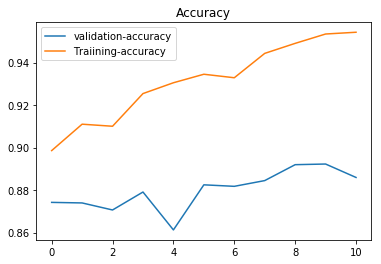

In [52]:
val_loss=trainingHistory.history['val_loss']
val_acc=trainingHistory.history['val_acc']
train_acc=trainingHistory.history['acc']
train_loss=trainingHistory.history['loss']

plt.plot(val_loss,label='validation-loss')
plt.plot(train_loss,label='Traiining-loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(val_acc,label='validation-accuracy')
plt.plot(train_acc,label='Traiining-accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

### Testing Images

In [60]:
def plot_images(idx):
    
    fig,axs=plt.subplots(1,3,figsize=(20,20))
    axs=axs.ravel()
    axs[0].imshow(images_list[idx])
    axs[0].set_title("Original Image")
    
    axs[1].imshow(np.reshape(images_list_anno[idx],(224,224)),cmap='gray')
    axs[1].set_title("Ground Truth")
    
    predict=new_model.predict(np.reshape(images_list[idx],(1,224,224,3)))
    axs[2].imshow(np.reshape(predict,(224,224)),cmap='gray')
    axs[2].set_title("Prediction")
    
    plt.show()

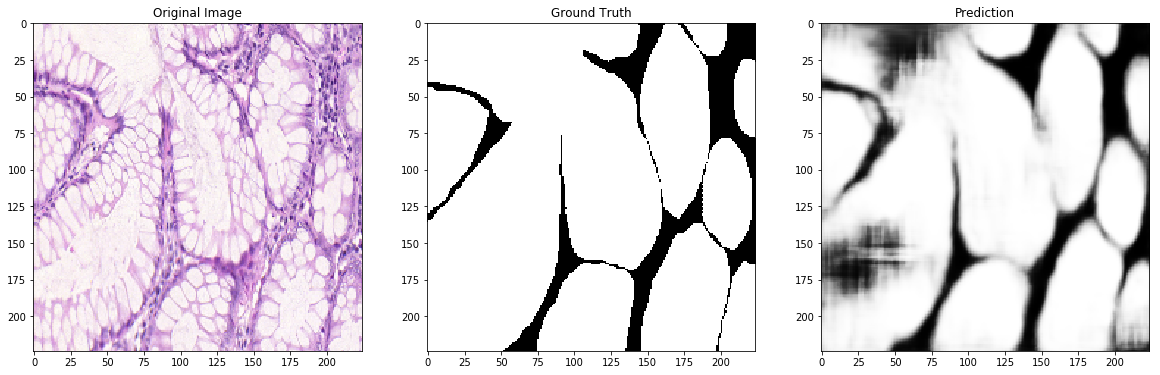

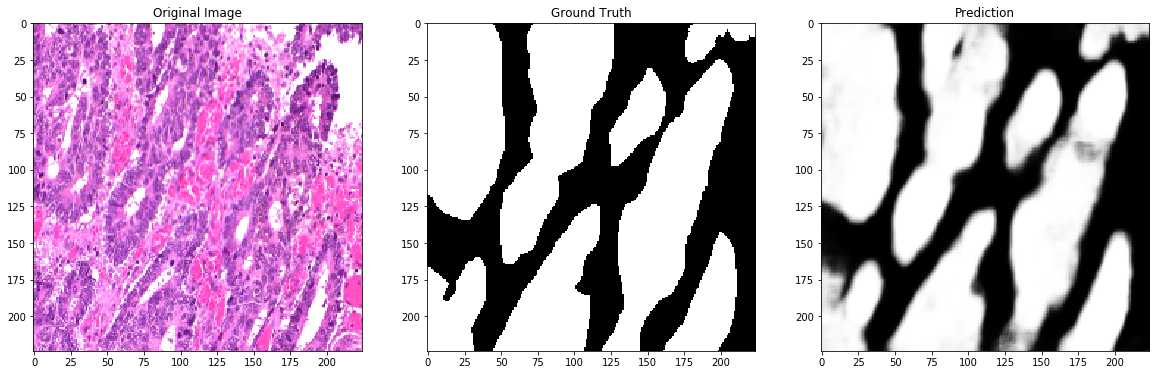

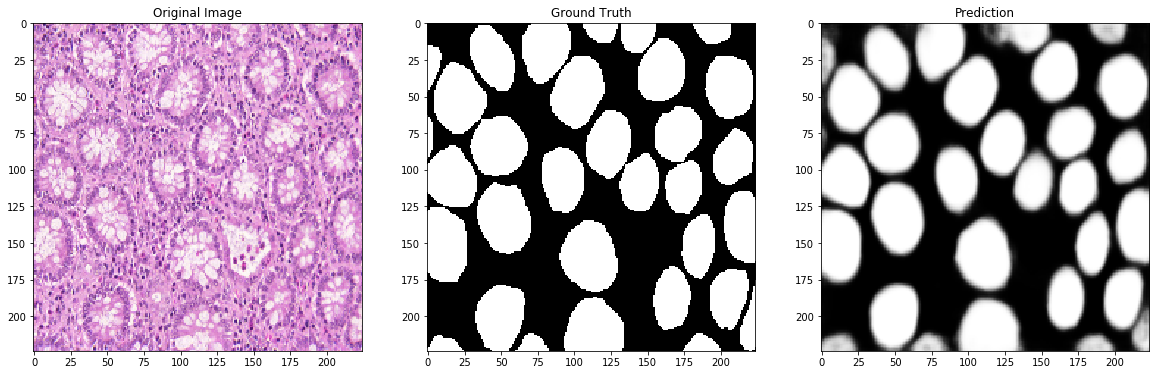

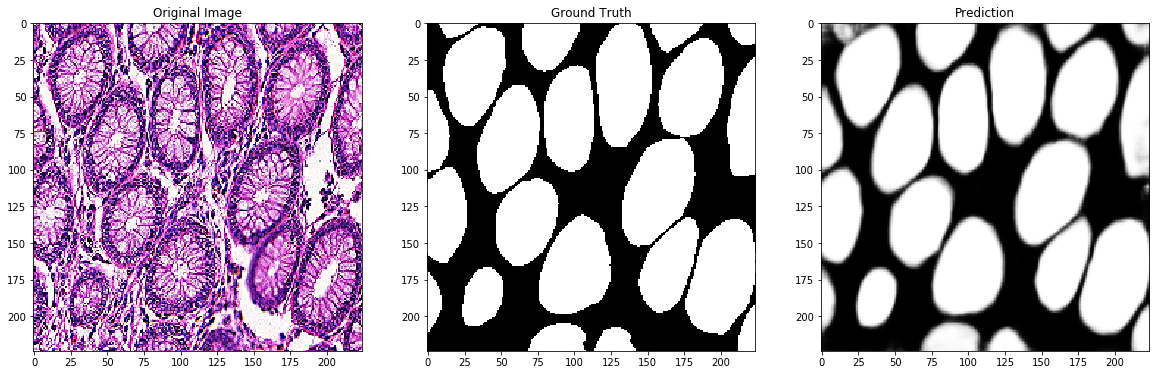

In [62]:
plot_images(3)
plot_images(30)
plot_images(83)
plot_images(300)

# [6] Conclusion

**To prevent dimensions dispute i have used 224*224 size images**<br>
**Accuracy of classification model was: - 99.09%**<br>
**Accuracy of Segmentation model was:-    93.43%  (Decrease of accuracy was due to overfitting)**<br>
**This can be further improved with hyperparameter tuning**